In [1]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

from pathlib import Path
from scipy import signal
from scipy.io import wavfile
from scipy.fftpack import fft
from torch.autograd import Variable
from sklearn.model_selection import train_test_split

%matplotlib inline

# Data processing

In [2]:
L = 16000
legal_labels = 'yes no up down left right on off stop go silence unknown'.split()
train_data_path = Path('./train/audio')

In [3]:
def unzip2(values):
    a, b = zip(*values)
    return list(a), list(b)


def list_of_wavs(directory, ext='wav'):
    return unzip2(path.parts[-2:] for path in directory.glob(f'*/*.{ext}'))

In [4]:
def custom_fft(y, fs):
    T = 1.0 / fs
    N = y.shape[0]
    yf = fft(y)
    xf = np.linspace(0.0, 1.0 / (2.0 * T), N // 2)
    vals = 2.0 / N * np.abs(yf[0 : N // 2])
    return xf, vals


def log_specgram(audio, sample_rate, window_size=20, step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                            fs=sample_rate,
                                            window='hann',
                                            nperseg=nperseg,
                                            noverlap=noverlap,
                                            detrend=False)
    
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

In [5]:
def pad_audio(samples):
    if len(samples) >= L: 
        return samples
    
    return np.pad(samples, pad_width=(L - len(samples), 0), mode='constant', constant_values=(0, 0))

    
def chop_audio(samples, L=16000, num=20):
    for i in range(num):
        beg = np.random.randint(0, len(samples) - L)
        yield samples[beg: beg + L]

        
def label_transform(labels):
    nlabels = []
    
    for label in labels:
        if label == '_background_noise_':
            nlabels.append('silence')
        elif label not in legal_labels:
            nlabels.append('unknown')
        else:
            nlabels.append(label)
            
    return pd.get_dummies(pd.Series(nlabels))

# Model

In [6]:
dropout = nn.Dropout(p=0.30)


class ConvRes(nn.Module):
    def __init__(self, insize, outsize):
        super(ConvRes, self).__init__()
        
        self.math = nn.Sequential(
            nn.BatchNorm2d(insize),
            torch.nn.Conv2d(insize, outsize, kernel_size=2, padding=2),
            nn.PReLU(),
        )

    def forward(self, x):
        return self.math(x)


class ConvCNN(nn.Module):
    def __init__(self, insize, outsize, kernel_size=7, padding=2, pool=2, avg=True):
        super(ConvCNN, self).__init__()
        self.avg = avg
        self.math = torch.nn.Sequential(
            torch.nn.Conv2d(insize, outsize, kernel_size=kernel_size, padding=padding),
            torch.nn.BatchNorm2d(outsize),
            torch.nn.LeakyReLU(),
            torch.nn.MaxPool2d(pool, pool),
        )
        self.avgpool = torch.nn.AvgPool2d(pool, pool)

    def forward(self, x):
        x = self.math(x)
        
        if self.avg is True:
            x = self.avgpool(x)
            
        return x


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
 
        self.avgpool = nn.AdaptiveAvgPool2d(1)

        self.cnn1 = ConvCNN(1, 32, kernel_size=7, pool=4, avg=False)
        self.cnn2 = ConvCNN(32, 32, kernel_size=5, pool=2, avg=True)
        self.cnn3 = ConvCNN(32, 32, kernel_size=5, pool=2, avg=True)

        self.res1 = ConvRes(32, 64)

        self.features = nn.Sequential(
            self.cnn1, 
            dropout,
            self.cnn2,
            self.cnn3,
            self.res1,
        )

        self.classifier = torch.nn.Sequential(
            nn.Linear(1024, 12),
        )
        self.sig = nn.Sigmoid()
  
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Testing

In [7]:
labels, files = list_of_wavs(train_data_path)

new_sample_rate = 8000
X = []
y = []

for label, file in zip(labels, files):
    sample_rate, samples = wavfile.read(train_data_path/label/file)
    samples = pad_audio(samples)
    
    if len(samples) > 16000:
        n_samples = chop_audio(samples)
    else: 
        n_samples = [samples]
        
    for samples in n_samples:
        resampled = signal.resample(samples, int(new_sample_rate / sample_rate * samples.shape[0]))
        _, _, specgram = log_specgram(resampled, sample_rate=new_sample_rate)
        X.append(specgram)
        y.append(label)
        
        
X = np.array(X)
shape = list(X.shape)
X = X.reshape([shape[0], 1, shape[1], shape[2]])
y = label_transform(y)

label_index = y.columns.values
y = np.array(y.values, dtype=np.float32)

/Users/rebryk/Projects/spbau/speech-env/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)

In [9]:
X_train = X_train[:20_000]
y_train = y_train[:20_000]

In [10]:
LR = 0.005
MOMENTUM = 0.9

model = Net()
loss_func = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=5e-5) #  L2 regularization

In [11]:
def chunks(X_train, y_train, size):
    for i in range(0, len(X_train), size):
        yield X_train[i : i + size], y_train[i : i + size]

In [12]:
def train(epoch, X_train, y_train, batch_size=20):
    n_total = len(X_train)
    last_batch = (n_total + batch_size - 1) // batch_size
    
    loss_history = []
    loss_batch_history = []

    model.train()
    
    for batch_idx, (data, target) in enumerate(chunks(X_train, y_train, batch_size), 1):
        data, target = torch.from_numpy(data), torch.from_numpy(target)
        data, target = Variable(data), Variable(target)
                 
        optimizer.zero_grad()
        preds = model(data)
        loss = loss_func(preds, target)
        loss.backward()
        optimizer.step()
        
        loss_batch_history.append(loss.data[0])
            
        if batch_idx % 100 == 0 or batch_idx == last_batch:
            loss_history.append(np.mean(loss_batch_history))
            loss_batch_history = []
            
            n_samples = min(batch_idx * len(data), n_total)
            progress = 100. * n_samples / n_total
            print(f'Train Epoch: {epoch} [{n_samples}/{n_total} ({progress:.0f}%)]\tLoss: {loss.data[0]:.6f}')
    
    return loss_history

In [13]:
def valid(X_valid, y_valid, batch_size=20):
    loss_history = []
    
    for batch_idx, (data, target) in enumerate(chunks(X_valid, y_valid, batch_size), 1):
        data, target = torch.from_numpy(data), torch.from_numpy(target)
        data, target = Variable(data), Variable(target)     
        preds = model(data)
        loss = loss_func(preds, target)
        loss_history.append(loss.data[0])
    
    return np.mean(loss_history)

Epoch 1
Train Epoch: 1 [2000/20000 (10%)]	Loss: 0.170587
Train Epoch: 1 [4000/20000 (20%)]	Loss: 0.198712
Train Epoch: 1 [6000/20000 (30%)]	Loss: 0.200468
Train Epoch: 1 [8000/20000 (40%)]	Loss: 0.134355
Train Epoch: 1 [10000/20000 (50%)]	Loss: 0.211007
Train Epoch: 1 [12000/20000 (60%)]	Loss: 0.152107
Train Epoch: 1 [14000/20000 (70%)]	Loss: 0.114944
Train Epoch: 1 [16000/20000 (80%)]	Loss: 0.151797
Train Epoch: 1 [18000/20000 (90%)]	Loss: 0.080425
Train Epoch: 1 [20000/20000 (100%)]	Loss: 0.067550
Epoch 2
Train Epoch: 2 [2000/20000 (10%)]	Loss: 0.101102
Train Epoch: 2 [4000/20000 (20%)]	Loss: 0.145506
Train Epoch: 2 [6000/20000 (30%)]	Loss: 0.142366
Train Epoch: 2 [8000/20000 (40%)]	Loss: 0.070246
Train Epoch: 2 [10000/20000 (50%)]	Loss: 0.098771
Train Epoch: 2 [12000/20000 (60%)]	Loss: 0.085083
Train Epoch: 2 [14000/20000 (70%)]	Loss: 0.098945
Train Epoch: 2 [16000/20000 (80%)]	Loss: 0.130326
Train Epoch: 2 [18000/20000 (90%)]	Loss: 0.078646
Train Epoch: 2 [20000/20000 (100%)]	Loss:

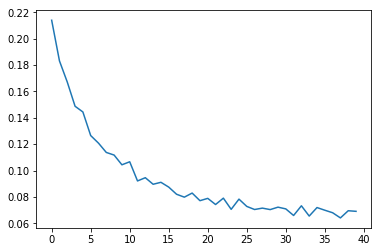

In [14]:
%%time

loss_history = []

for epoch in range(1, 5):
    print("Epoch %d" % epoch)
    loss_history += train(epoch, X_train, y_train)
    
plt.plot(loss_history);

In [15]:
%%time
valid(X_valid, y_valid)

CPU times: user 25.4 s, sys: 4.54 s, total: 30 s
Wall time: 24.7 s


0.066756368462856